In [6]:
import nltk
import random
import string
from nltk.corpus import movie_reviews, stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.classify import NaiveBayesClassifier
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


nltk.download('movie_reviews')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')


[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\megha\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\megha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\megha\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\megha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)


documents = [(movie_reviews.words(fileid), category) for category in movie_reviews.categories() for fileid in movie_reviews.fileids(category)]
random.shuffle(documents)


In [8]:

def get_simple_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


def clean_review(words):
    output_words = []
    for w in words:
        if w.lower() not in stop_words and w not in punctuation:
            pos = pos_tag([w])[0][1]
            lemmatized_word = lemmatizer.lemmatize(w, pos=get_simple_pos(pos))
            output_words.append(lemmatized_word)
    return output_words


documents = [(clean_review(document), category) for document, category in documents]


In [9]:

training_documents = documents[:1500]
testing_documents = documents[1500:]


all_words = [word for doc in training_documents for word in doc[0]]
freq_dist = nltk.FreqDist(all_words)
features = [word for word, _ in freq_dist.most_common(3000)]


def get_feature_dict(words):
    return {word: (word in words) for word in features}


training_data = [(get_feature_dict(doc), category) for doc, category in training_documents]
testing_data = [(get_feature_dict(doc), category) for doc, category in testing_documents]


In [10]:

training_documents = documents[:1500]
testing_documents = documents[1500:]


all_words = [word for doc in training_documents for word in doc[0]]
freq_dist = nltk.FreqDist(all_words)
features = [word for word, _ in freq_dist.most_common(3000)]

def get_feature_dict(words):
    return {word: (word in words) for word in features}

training_data = [(get_feature_dict(doc), category) for doc, category in training_documents]
testing_data = [(get_feature_dict(doc), category) for doc, category in testing_documents]


In [11]:

classifier_nb = NaiveBayesClassifier.train(training_data)

accuracy_nb = nltk.classify.accuracy(classifier_nb, testing_data)
print(f"Naive Bayes Classifier Accuracy: {accuracy_nb * 100:.2f}%")
classifier_nb.show_most_informative_features(15)


classifier_svm = SklearnClassifier(SVC())
classifier_svm.train(training_data)

accuracy_svm = nltk.classify.accuracy(classifier_svm, testing_data)
print(f"SVM Classifier Accuracy: {accuracy_svm * 100:.2f}%")


Naive Bayes Classifier Accuracy: 78.20%
Most Informative Features
                 comfort = True              pos : neg    =     10.8 : 1.0
             outstanding = True              pos : neg    =     10.6 : 1.0
                 freddie = True              neg : pos    =     10.1 : 1.0
                  prinze = True              neg : pos    =     10.1 : 1.0
            breathtaking = True              pos : neg    =      9.2 : 1.0
                  seagal = True              neg : pos    =      8.8 : 1.0
               ludicrous = True              neg : pos    =      8.5 : 1.0
                   awful = True              neg : pos    =      7.9 : 1.0
                   mulan = True              pos : neg    =      7.8 : 1.0
            respectively = True              pos : neg    =      7.7 : 1.0
                lifeless = True              neg : pos    =      7.7 : 1.0
                  martha = True              neg : pos    =      7.5 : 1.0
                   anger = True   

C:\Users\megha\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


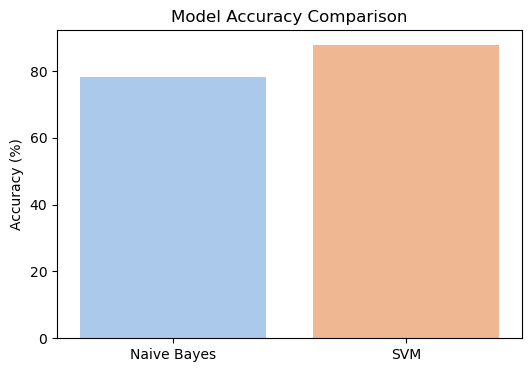

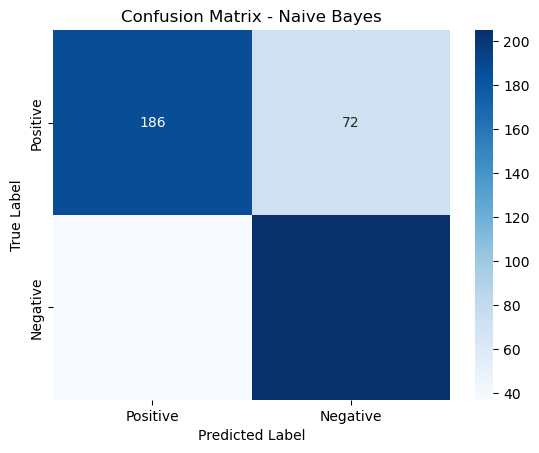

Naive Bayes Classification Report:
              precision    recall  f1-score   support

         neg       0.74      0.85      0.79       242
         pos       0.83      0.72      0.77       258

    accuracy                           0.78       500
   macro avg       0.79      0.78      0.78       500
weighted avg       0.79      0.78      0.78       500



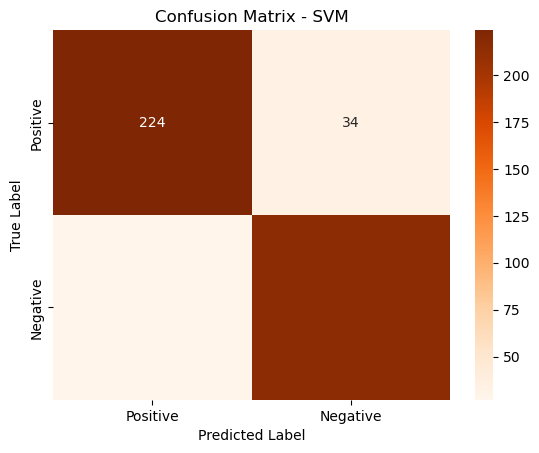

SVM Classification Report:
              precision    recall  f1-score   support

         neg       0.86      0.89      0.88       242
         pos       0.89      0.87      0.88       258

    accuracy                           0.88       500
   macro avg       0.88      0.88      0.88       500
weighted avg       0.88      0.88      0.88       500



In [12]:

y_true = [category for _, category in testing_documents]
y_pred_nb = [classifier_nb.classify(get_feature_dict(doc)) for doc, _ in testing_documents]
y_pred_svm = [classifier_svm.classify(get_feature_dict(doc)) for doc, _ in testing_documents]


plt.figure(figsize=(6, 4))
accuracy_scores = [accuracy_nb * 100, accuracy_svm * 100]
models = ['Naive Bayes', 'SVM']
sns.barplot(x=models, y=accuracy_scores, palette='pastel')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy Comparison')
plt.show()


conf_matrix_nb = confusion_matrix(y_true, y_pred_nb, labels=["pos", "neg"])
sns.heatmap(conf_matrix_nb, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Negative'], yticklabels=['Positive', 'Negative'])
plt.title('Confusion Matrix - Naive Bayes')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


print("Naive Bayes Classification Report:")
print(classification_report(y_true, y_pred_nb))


conf_matrix_svm = confusion_matrix(y_true, y_pred_svm, labels=["pos", "neg"])
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Oranges', xticklabels=['Positive', 'Negative'], yticklabels=['Positive', 'Negative'])
plt.title('Confusion Matrix - SVM')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


print("SVM Classification Report:")
print(classification_report(y_true, y_pred_svm))
